In [1]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
from tqdm.auto import tqdm
import time
from qutip import *
import numpy as np
import matplotlib.pyplot as plt
import kwant
import math
from math import  sqrt
import cmath
from numpy.lib.scimath import sqrt as csqrt
import scipy
from scipy.optimize import fsolve
import copy

In [2]:
# Defining the Jordan Wigner transformation for a 1D lattice
def jordan_wigner_transform(j, lattice_length):
    for k in range(j):
        if k == 0:
            operators = sigmaz()
        else:
            operators = tensor(operators, sigmaz())
    if j == 0:
        operators = sigmap()
    else:
        operators = tensor(operators, sigmap())
    for k in range(lattice_length - j - 1):
        operators = tensor(operators, identity(2))
    return operators

# Define rho0 distribution
def Lorentzian(omega, Gamma, poles):
    Rho0 = Gamma / np.pi / (omega ** 2 + Gamma ** 2)
    p = np.random.uniform(0, 1, poles)
    Rhoint = np.zeros(poles)
    for i in range(len(p)):
        Rhoint[i] = Gamma * math.tan(np.pi * (p[i] - 1 / 2))  ###p[i]-1/2
    return Rho0, Rhoint

# Calculates parameters impengergy,bathenergy and Vkk from random sampling distribution
def nonintG(omega, eta, select):
    G = 0
    for i in range(len(select)):
        G = G + 1 / len(select) / (omega - select[i] + 1.j * eta)
    return G

def HamiltonianAIM(c, impengergy, bathenergy, Vkk, U, Sigma):
    H = 0
    for i in range(2):
        H += impengergy * (c[i].dag() * c[i])
        for j in range(len(bathenergy)):
            H += Vkk[j] * (c[i].dag() * c[2 * j + i + 2] + c[2 * j + i + 2].dag() * c[i])
            H += bathenergy[j] * (c[2 * j + i + 2].dag() * c[2 * j + i + 2])
    exp = np.dot(H.eigenstates()[1][0].dag(), np.dot(n, H.eigenstates()[1][0]))
    Eg=H.eigenstates()[0][0]
    H += U * (c[0].dag() * c[0] * c[1].dag() * c[1])
    H += -Sigma * (c[0].dag() * c[0] + c[1].dag() * c[1])
    return H,exp,Eg

def MBGAIM(omega, eigs, c, eta,Tk):
    #for t in range(len(Tk)):
    MBG=np.zeros(len(omega),dtype = 'complex_')
    Z=-eigs[0][0]/Tk
    for i in range(1,len(eigs[0])):
        Z = np.logaddexp(Z, -eigs[0][i]/Tk)
        #Z+=np.exp(-eigs[0][i]/Tk, dtype=np.longdouble)
    eigs2=copy.deepcopy(eigs[1])
    for i in range(len(eigs[1])):
        eigs2[i]=eigs2[i].dag()
    expA=np.reshape(eigs2,(len(eigs[1]),1))*c[0]*np.reshape(eigs[1],(1,len(eigs[1])))
    exp2A=np.reshape(eigs2,(len(eigs[1]),1))*c[0].dag()*np.reshape(eigs[1],(1,len(eigs[1])))
    for i in range(len(eigs[0])):
        for j in range(len(eigs[0])):
            #exp=np.dot(eigs[1][i].dag(),np.dot(c[0],eigs[1][j]))#m
            #exp2=np.dot(eigs[1][j].dag(),np.dot(c[0].dag(),eigs[1][i]))#j
            #exp3=np.dot(eigs[1][i].dag(),np.dot(c[0].dag(),eigs[1][j]))
            #exp4=np.dot(eigs[1][j].dag(),np.dot(c[0],eigs[1][i]))
            exp=expA[i][j]
            exp2=exp2A[j][i]
            exp3=exp2A[i][j]
            exp4=expA[j][i]
            k=exp[0][0][0]*exp2[0][0][0]
            l=exp3[0][0][0]*exp4[0][0][0]
            final = k / (omega + eigs[0][i] - eigs[0][j] + 1.j * eta) + l / (omega + eigs[0][j] - eigs[0][i] + 1.j * eta)
            ratio=-eigs[0][i]/Tk-Z
            MBG += final*np.exp(ratio)
            print("--- %s s second part %d %d %d ---" % ((time.time() - start_time) ,Tk,i,j), end='\r')
    #print(Z,-eigs[0][i]/Tk,ratio)
    return MBG

def find_nearest(array, value,eigs):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return eigs[idx]
#test this
def find_nearest2(array, value,eigs):
    for i in range(len(array)):
        if np.isclose(array[i], value, atol=0.1):
            idx=i
            break
    #print(array,value,idx)
    return eigs[idx]

# Gives Green’s function for the impurity level in the full interacting system (up and down spin)
def AIMsolver(impengergy, bathenergy, Vkk, U, Sigma, omega, eta, c,Tk,reset,error):
    H,exp2,Eg1 = HamiltonianAIM(c, impengergy, bathenergy, Vkk, U, Sigma)
    print("--- %s s first part ---" % ((time.time() - start_time)), end='\r')
    try:
        eigs=H.eigenstates()
    except np.linalg.LinAlgError:
        error=True
    exp=[]
    for i in range(len(eigs[1])):
        exp.append(np.dot(eigs[1][i].dag(), np.dot(n, eigs[1][i])))
    E0=find_nearest2(exp, exp2[0][0],eigs[0])
    MBG = np.full((len(Tk), len(omega)), np.zeros(len(omega),dtype = 'complex_'))
    Boltzmann=[]
    for t in range(len(Tk)):
        Boltzmann.append(np.exp(-abs(E0-eigs[0][0])/Tk[t]))
        if Boltzmann[t]==0:
            MBG[t] = np.zeros(len(omega),dtype = 'complex_')
        else:
            MBG[t] = MBGAIM(omega, eigs, c, eta,Tk[t])
    #if exp==exp2:
    #    reset=True
    #    print(Eg1,eigs[0][0],exp[0][0],exp2[0][0])
    #Boltzmann=np.exp(-abs(exp[0][0]-exp2[0][0])/Tk)
    reset=True
    return MBG,Boltzmann,reset,error

def Pcal(poles,pos):
    di=np.full((poles-1, poles), np.zeros(poles))
    for i in range(poles-1):
        for j in range(poles-1):
            if j>=i:
                di[i][j+1]=-1/sqrt((poles-i-1)*(poles-i))
        di[i][i]=sqrt(poles-i-1)/sqrt(poles-i)
    di=np.insert(di, pos,1/sqrt(poles),axis=0)
    return di

def DPgen(poles,select,pos):
    Pbath =np.array(Pcal(poles,pos))
    s = (poles,poles)
    Dbath=np.zeros(s)
    for i in range(len(select)):
        Dbath[i][i]=select[i]
    M=np.dot(Pbath,np.dot(Dbath,Pbath.T))
    return M

def startrans(poles,select,row,col):
    ham_mat=DPgen(poles,select,row)
    Hkk=np.delete(np.delete(ham_mat,row,axis=0),row,axis=1)
    eigkk,veckk=np.linalg.eig(Hkk)
    pbar=np.insert(np.insert(veckk, row,0,axis=0),row,0,axis=1)
    pbar[row][row]=1
    Hp=np.dot(pbar.T,np.dot(ham_mat,pbar))
    return Hp

In [4]:
import DEDlib

def Startrans(poles,select,row,omega, eta):
    """Startrans(poles,select,row,omega, eta). 
Function to transform 1D lattice matrices in order to calculates parameters impengergy, bathenergy and Vkk from random sampling distribution."""
    di=np.full((poles-1, poles), np.zeros(poles))
    for i in range(poles-1):
        for j in (j for j in range(poles-1) if j>=i): di[i][j+1]=-1/sqrt((poles-i-1)*(poles-i))
        di[i][i]=sqrt(poles-i-1)/sqrt(poles-i)
    Pbath,Dbath=np.insert(di, row,1/sqrt(poles),axis=0),np.zeros((poles,poles))
    for i, _ in enumerate(select): Dbath[i][i]=select[i]
    pbar=np.insert(np.insert(np.linalg.eig(np.delete(np.delete(np.dot(Pbath,np.dot(Dbath,Pbath.T)),row,axis=0),row,axis=1))[1], row,0,axis=0),row,0,axis=1)
    pbar[row][row]=1
    return np.dot(pbar.T,np.dot(np.dot(Pbath,np.dot(Dbath,Pbath.T)),pbar)),sum([1 / len(select) / (omega - select[i] + 1.j * eta) for i, _ in enumerate(select)])

def Jordan_wigner_transform(j, lattice_length):
    """Jordan_wigner_transform(j, lattice_length). 
Defines the Jordan Wigner transformation for a 1D lattice."""
    operators = sigmaz()
    for _ in range(j-1): operators = tensor(operators, sigmaz())
    if j == 0: operators = sigmam()
    else: operators = tensor(operators, sigmam())
    for _ in range(lattice_length - j - 1): operators = tensor(operators, identity(2))
    return operators

def Lorentziant(omega, Gamma, poles,Ed=-3/2,Sigma=3/2):
    """Lorentzian(omega, Gamma, poles,Ed=-3/2,Sigma=3/2). 
Defines the non-interacting DOS (rho0) and selects random sites based on the number of sites in the 1D lattice model and the calculated distribution."""
    p = np.random.uniform(0, 1, poles)
    return -np.imag(1/(omega-Ed-Sigma+1j*Gamma))/np.pi, np.array([Gamma * math.tan(np.pi * (p[i] - 1 / 2))+Ed+Sigma for i in range(poles)])

def HamiltonianAIM(c, impenergy, bathenergy, Vkk, U, Sigma, H = 0):
    """HamiltonianAIM(c, impenergy, bathenergy, Vkk, U, Sigma). 
Based on energy parameters calculates the Hamiltonian of a single-impurity system."""
    for i in range(2):
        H += impenergy * (c[i].dag() * c[i])
        for j, bathE in enumerate(bathenergy):
            H += Vkk[j] * (c[i].dag() * c[2 * j + i + 2] + c[2 * j + i + 2].dag() * c[i])+ bathE * (c[2 * j + i + 2].dag() * c[2 * j + i + 2])
    return H,H+U * (c[0].dag() * c[0] * c[1].dag() * c[1])-Sigma * (c[0].dag() * c[0] + c[1].dag() * c[1])

def Constraint(ctype,H0,H,omega,eta,c,n,Tk):
    """Constraint(ctype,H0,H,omega,eta,c,n). 
Constraint implementation function for DED method with various possible constraints."""
    if ctype=='snb':
        vecs=scipy.linalg.eigh(H0.data.toarray(),eigvals=[0, 0])[1][:,0]
        evals, evecs =scipy.linalg.eigh(H.data.toarray())
        return MBGAIM(omega, H, c, eta,Tk,np.exp(-abs(evals[find_nearest(np.diag(np.conj(evecs).T@n.data@evecs),np.conj(vecs)@n.data@vecs.T)]-evals[0])/Tk),evals, evecs),True
    elif ctype[0]=='n':
        vecs=scipy.sparse.csr_matrix(np.vstack((scipy.sparse.linalg.eigsh(np.real(H0.data), k=1, which='SA')[1][:,0],
                                                scipy.sparse.linalg.eigsh(np.real(H.data), k=1, which='SA')[1][:,0])))
        exp=np.conj(vecs)@n.data@vecs.T
        if ctype=='n%2' and int(np.round(exp[0,0]))%2==int(np.round(exp[1,1]))%2:
            return MBGAIM(omega, H, c, eta,Tk,np.ones(len(Tk))),True
        elif ctype=='n' and np.round(exp[0,0])==np.round(exp[1,1]):
            return MBGAIM(omega, H, c, eta,Tk,np.ones(len(Tk))),True
        else:
            return (np.zeros(len(omega),dtype = 'complex_'),np.zeros(len(Tk)),np.array([])),False
    elif ctype[0]=='d':
        vecs=scipy.sparse.csr_matrix(np.vstack((scipy.linalg.eigh(H.data.toarray(),eigvals=[0, 0])[1][:,0],
                                                scipy.linalg.eigh(H0.data.toarray(),eigvals=[0, 0])[1][:,0])))
        exp=np.conj(vecs)@n.data@vecs.T
        if ctype=='dn' and np.round(exp[0,0])==np.round(exp[1,1]):
            return MBGAIM(omega, H, c, eta,Tk,np.ones(len(Tk))),True
        else:
            return (np.zeros(len(omega),dtype = 'complex_'),np.zeros(len(Tk)),np.array([])),False
    else:
        return MBGAIM(omega, H, c, eta,Tk,np.ones(len(Tk))),True

def find_nearest(array,value):
    for i in (i for i,arrval in enumerate(array) if np.isclose(arrval, value, atol=0.1)): return i

def MBGAIM(omega, H, c, eta,Tk,Boltzmann,evals=[],evecs=[]):
    """MBGAIM(omega, H, c, eta). 
Calculates the many body Green's function based on the Hamiltonian eigenenergies/-states."""
    if evals==[]: evals, evecs =scipy.linalg.eigh(H.data.toarray())
    if Tk==[0]:
        vecn=np.conj(evecs[:,1:]).T
        exp,exp2=vecn@c[0].data.tocoo()@evecs[:,0],vecn@c[0].dag().data.tocoo()@evecs[:,0]
        return sum([abs(expi)** 2 / (omega + evals[i+1] - evals[0] + 1.j * eta) + 
                        abs(exp2[i])** 2 / (omega + evals[0] - evals[i+1] + 1.j * eta) for i,expi in enumerate(exp)]),Boltzmann,evecs[:,0]
    else:
        MGdat=np.zeros((len(Tk),len(omega)),dtype = 'complex_')
        for k,T in enumerate(Tk):
            if Boltzmann[k]!=0:
                eevals=np.exp(-evals/T-scipy.special.logsumexp(-evals/T))
                vecn=np.conj(evecs).T
                exp,exp2=vecn@c[0].data.tocoo()@evecs,vecn@c[0].dag().data.tocoo()@evecs
                MGdat[k,:]=sum([(exp[i][j]*exp2[j][i]/ (omega + evi - evj + 1.j * eta) + 
                            exp[j][i]*exp2[i][j]/ (omega + evj - evi + 1.j * eta))*eevals[i] for i,evi in enumerate(evals) for j,evj in enumerate(evals)])
        return MGdat.squeeze(),Boltzmann,evecs[:,0]

In [8]:
omega= np.linspace(-3,3,1001)
eta=0.02*abs(omega)+1e-24#0.000001
#eta[int(np.round(len(eta)/2))]=0.0001
N=200
poles=4
U=3
Sigma=U/2
Gamma=0.3
lattice_length = 2+2*(poles-1)
c = []
for i in range(lattice_length):
    c.append(Jordan_wigner_transform(i, lattice_length))
n=0
for i in range(lattice_length):
    n+=c[i].dag()*c[i]
Tk=[1]#0.001,0.01,0.1,1
fDOS=np.full((len(Tk), len(omega)), np.zeros(len(omega),dtype = 'complex_'))
BoltzmannT=np.zeros(len(Tk),dtype = 'complex_')
noninttot3=0
noninttot4=0
n,AvgSigmadat,Nfin,nd=sum([c[i].dag()*c[i] for i in range(2*poles)]),np.zeros((len(Tk),1001),dtype = 'complex_'),np.zeros(len(Tk),dtype = 'float'),np.zeros(len(Tk),dtype = 'complex_')
    
for i in tqdm(range(N)):
    attempts=0
    reset=False
    error=False
    while not reset:
        select=sorted(Lorentziant(omega, Gamma, poles)[1])
        NewM,nonG=Startrans(poles,select,0,omega, eta)
        H0,H= HamiltonianAIM(c, NewM[0][0], [NewM[k+1][k+1] for k in range(len(NewM)-1)],NewM[0,1:], U, Sigma)
        #try:
        #    vecs=scipy.linalg.eigh(H0.data.toarray(),eigvals=[0, 0])[1][:,0]
        #    evals, evecs =scipy.linalg.eigh(H.data.toarray())
        #    exp2=np.conj(vecs)@n.data@vecs.T
        #except np.linalg.LinAlgError:
        #    error=True
        #test=np.diag(np.conj(evecs).T@n.data@evecs)
        #E0=evals[find_nearest(test, exp2)]
        #MBG = np.full((len(Tk), len(omega)), np.zeros(len(omega),dtype = 'complex_'))
        #Boltzmann=[]
        #for t in range(len(Tk)):
        #    Boltzmann.append(np.exp(-abs(E0-evals[0])/Tk[t]))
        #    if Boltzmann[t]==0:
        #        MBG[t] = np.zeros(len(omega),dtype = 'complex_')
        #    else:
        #        MBG[t] = MBGAIMt(omega, H, c, eta,Tk,Boltzmann)
        try:
            (MBGdat,Boltzmann,Ev0),reset=Constraint('snb',H0,H,omega,eta,c,n,Tk)
        except (np.linalg.LinAlgError,ValueError,scipy.sparse.linalg.ArpackNoConvergence):
            (MBGdat,Boltzmann,Ev0),reset=(np.zeros(len(omega),dtype = 'complex_'),np.zeros(len(Tk)),np.array([])),False
        if np.isnan(MBGdat).any() or error:
            reset=False


    Nfin,AvgSigmadat,nd=Nfin+Boltzmann,AvgSigmadat+(1/nonG-1/MBGdat+Sigma)*Boltzmann[:,None],nd+np.conj(Ev0).T@(c[0].dag() * c[0] + c[1].dag() * c[1]).data.tocoo()@Ev0*Boltzmann
    #for l in range(len(Tk)):
    #    if Boltzmann[l]!=0:
    #        NewSigmadat=(1/nonG-1/MBG[l]+Sigma)*Boltzmann[l]
    #        AvgSigmadat[l]=AvgSigmadat[l]+NewSigmadat
    #        BoltzmannT[l]+=Boltzmann[l]

  0%|          | 0/200 [00:00<?, ?it/s]

C:\Users\roelv\AppData\Local\Temp\ipykernel_27728\3424618557.py:75: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if evals==[]: evals, evecs =scipy.linalg.eigh(H.data.toarray())


[0.+0.j]
(2.655945028618121-2.259164726019072j)


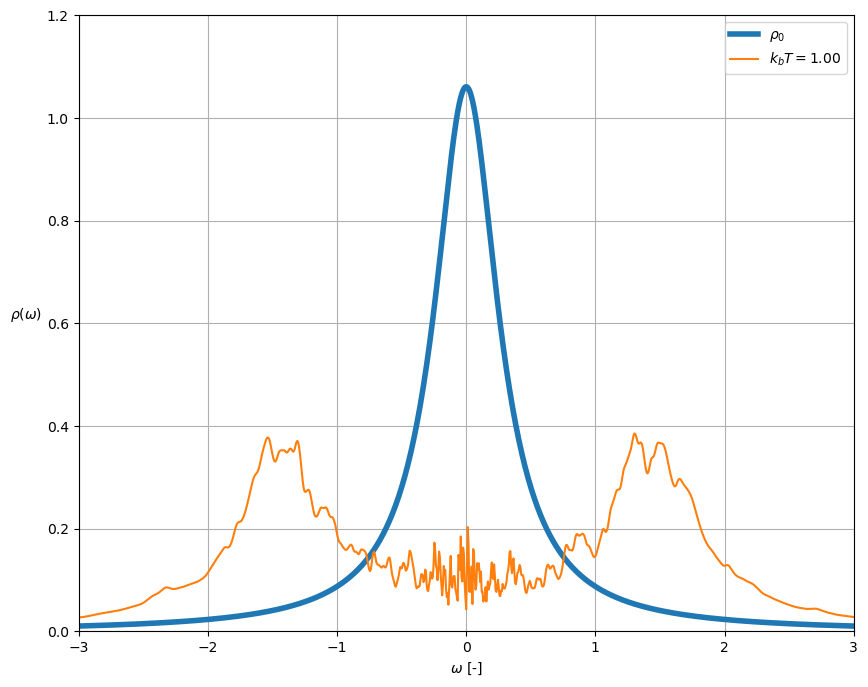

In [9]:
Ed=-Sigma
for l in range(len(Tk)):
    #AvgSigmadat+=Sigma
    #if l==0:
    #    Ed=-AvgSigmadat[500]
    finalG=np.nan_to_num(1/(omega-AvgSigmadat[l]/Nfin[l]-Ed+1j*Gamma))
    fDOS[l]=-np.imag(finalG)/np.pi
print(BoltzmannT)
print(AvgSigmadat[0][500])
#fDOS3=-np.imag(noninttot3)/np.pi
#fDOS4=-np.imag(noninttot4)/np.pi
plt.figure(figsize=(10,8))
plt.xlim(min(omega), max(omega))
plt.gca().set_ylim(bottom=0,top=1.2)
plt.xlabel("$\\omega$ [-]")
plt.gca().set_ylabel("$\\rho$($\\omega$)",va="bottom", rotation=0,labelpad=15)
plt.plot(omega,DEDlib.Lorentzian(omega,Gamma,poles)[0],linewidth=4,label='$\\rho_0$')
for i in range(len(Tk)):
    plt.plot(omega, fDOS[i],label='$k_bT= %.2f$'%Tk[i])
#plt.plot(omega, fDOS3,label='$\\rho$')
#plt.plot(omega, fDOS4,label='$\\rho$')
plt.legend()
plt.grid()

[1756.97233668+0.j]
(255.80405824051226-9339.29783647418j)


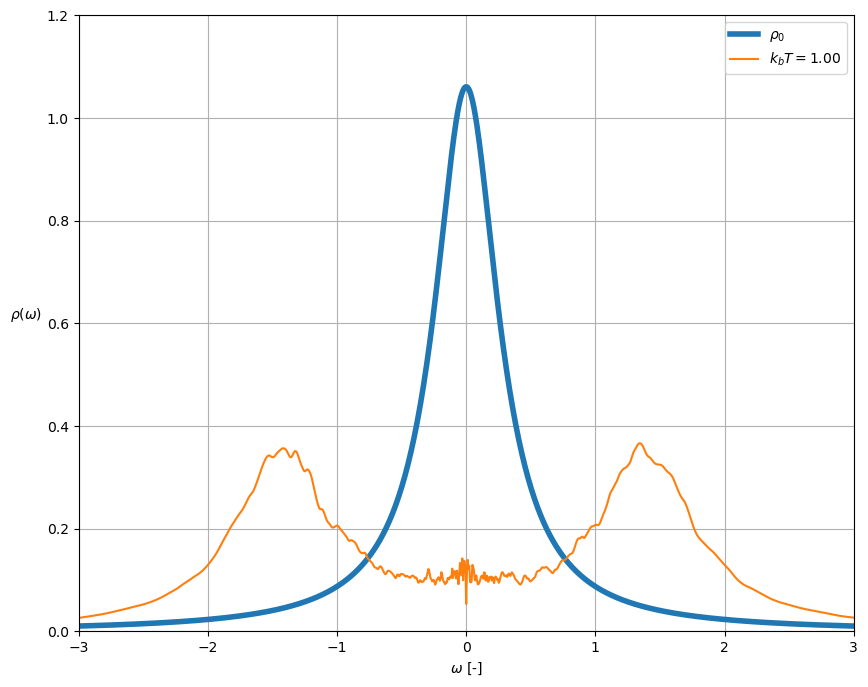

In [14]:
Ed=-Sigma
for l in range(len(Tk)):
    #AvgSigmadat+=Sigma
    #if l==0:
    #    Ed=-AvgSigmadat[500]
    finalG=np.nan_to_num(1/(omega-AvgSigmadat[l]/BoltzmannT[l]-Ed+1j*Gamma))
    fDOS[l]=-np.imag(finalG)/np.pi
print(BoltzmannT)
print(AvgSigmadat[0][500])
#fDOS3=-np.imag(noninttot3)/np.pi
#fDOS4=-np.imag(noninttot4)/np.pi
plt.figure(figsize=(10,8))
plt.xlim(min(omega), max(omega))
plt.gca().set_ylim(bottom=0,top=1.2)
plt.xlabel("$\\omega$ [-]")
plt.gca().set_ylabel("$\\rho$($\\omega$)",va="bottom", rotation=0,labelpad=15)
plt.plot(omega,DEDlib.Lorentzian(omega,Gamma,poles)[0],linewidth=4,label='$\\rho_0$')
for i in range(len(Tk)):
    plt.plot(omega, fDOS[i],label='$k_bT= %.2f$'%Tk[i])
#plt.plot(omega, fDOS3,label='$\\rho$')
#plt.plot(omega, fDOS4,label='$\\rho$')
plt.legend()
plt.grid()

In [11]:
import DEDlib
input=[{"N" : 200, "poles" : 4, "Ed" : -3/2, "etaco" : [0.02,1e-24], "ctype" : 'snb', "Tk" : [0.000000000001,0.01,1]}]
filenames,labelnames,conname=['cN4pT1e-12','cN4pT1e-2','cN4pT1'],['$\it{k_bT= %.3f}$'%0.000,'$\it{k_bT= %.3f}$'%0.010,'$\it{k_bT= %.3f}$'%1.000],['','no','soft']
DOST=np.zeros((len(input),len(input[0]["Tk"]),1001),dtype = 'complex_')
j=0#vary this###############################
inpt=input[j]
nd, Avgs, DOST[j], Lor, omega, selectpT, selectpcT=DEDlib.main(**inpt)
i=0
file=filenames[i]
DEDlib.DOSplot(DOST[j][i], Lor, omega,conname[j]+file,labelnames[i])
i=1
file=filenames[i]
DEDlib.DOSplot(DOST[j][i], Lor, omega,conname[j]+file,labelnames[i])
i=2
file=filenames[i]
DEDlib.DOSplot(DOST[j][i], Lor, omega,conname[j]+file,labelnames[i])
print(nd)

Iterations:   0%|          | 0/200 [00:00<?, ?it/s]

In [ ]:
import DEDlib
input=[{"N" : 2000, "poles" : 4, "Ed" : -3/2, "etaco" : [0.02,1e-24], "ctype" : 'snb', "Tk" : [0.000000000001,0.01,1]}]
filenames,labelnames,conname=['cN4pT1e-12','cN4pT1e-2','cN4pT1'],['$\it{k_bT= %.3f}$'%0.000,'$\it{k_bT= %.3f}$'%0.010,'$\it{k_bT= %.3f}$'%1.000],['','no','soft']
DOST=np.zeros((len(input),len(input[0]["Tk"]),1001),dtype = 'complex_')
j=0#vary this###############################
inpt=input[j]
nd, Avgs, DOST[j], Lor, omega, selectpT, selectpcT=DEDlib.main(**inpt)
i=0
file=filenames[i]
DEDlib.DOSplot(DOST[j][i], Lor, omega,conname[j]+file,labelnames[i])
i=1
file=filenames[i]
DEDlib.DOSplot(DOST[j][i], Lor, omega,conname[j]+file,labelnames[i])
i=2
file=filenames[i]
DEDlib.DOSplot(DOST[j][i], Lor, omega,conname[j]+file,labelnames[i])
print(nd)

[757.+0.j]
(1141.2575043651152-0.0960354748514113j)


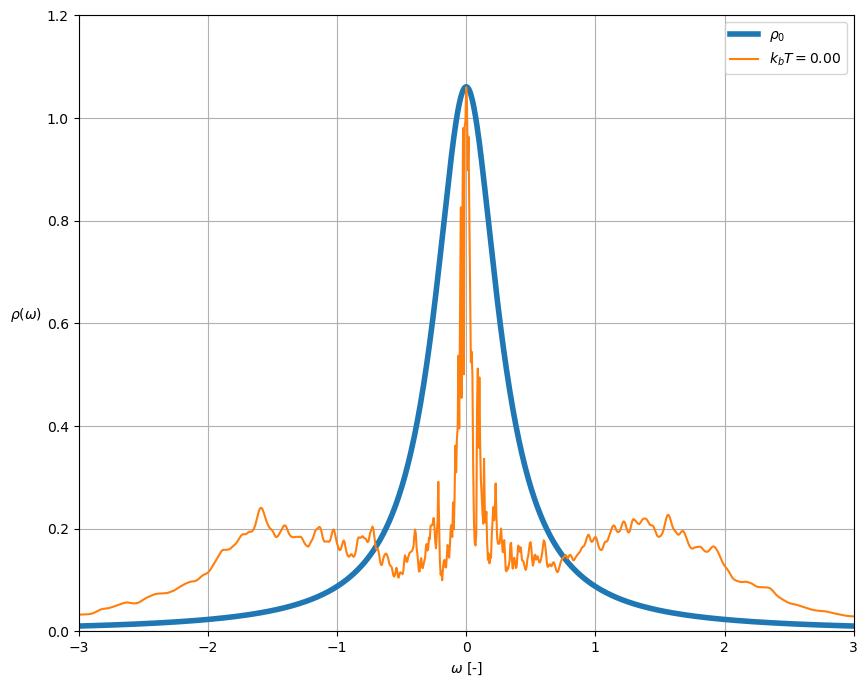

In [5]:
Ed=-Sigma
for l in range(len(Tk)):
    #AvgSigmadat+=Sigma
    #if l==0:
    #    Ed=-AvgSigmadat[500]
    finalG=np.nan_to_num(1/(omega-AvgSigmadat[l]/BoltzmannT[l]-Ed+1j*Gamma))
    fDOS[l]=-np.imag(finalG)/np.pi
print(BoltzmannT)
print(AvgSigmadat[0][500])
#fDOS3=-np.imag(noninttot3)/np.pi
#fDOS4=-np.imag(noninttot4)/np.pi
plt.figure(figsize=(10,8))
plt.xlim(min(omega), max(omega))
plt.gca().set_ylim(bottom=0,top=1.2)
plt.xlabel("$\\omega$ [-]")
plt.gca().set_ylabel("$\\rho$($\\omega$)",va="bottom", rotation=0,labelpad=15)
plt.plot(omega,Lorentzian(omega,Gamma,poles)[0],linewidth=4,label='$\\rho_0$')
for i in range(len(Tk)):
    plt.plot(omega, fDOS[i],label='$k_bT= %.2f$'%Tk[i])
#plt.plot(omega, fDOS3,label='$\\rho$')
#plt.plot(omega, fDOS4,label='$\\rho$')
plt.legend()
plt.grid()

[1517.+0.j]
(13.240176164302294-3.353566368044454j)


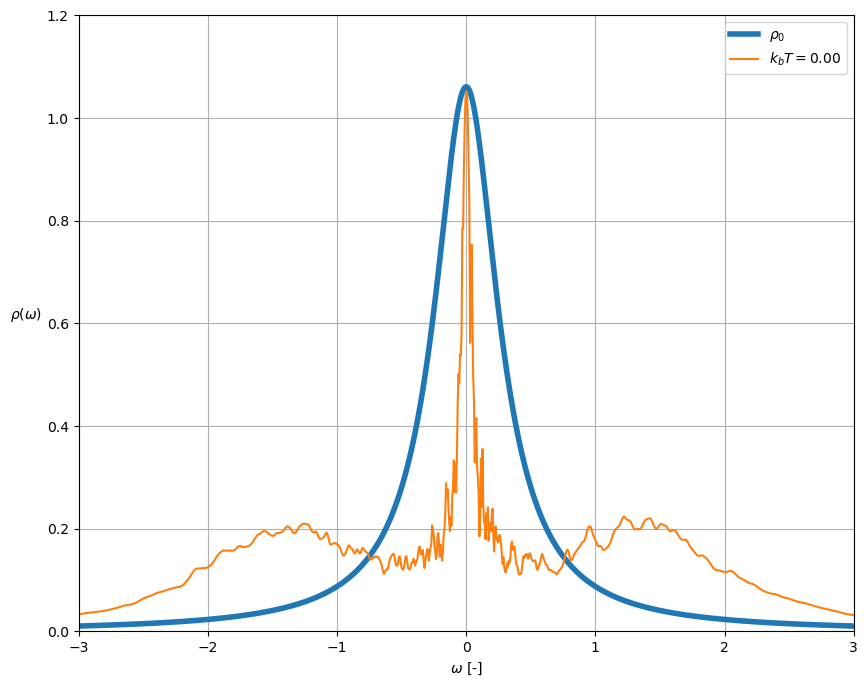

In [86]:
for l in range(len(Tk)):
    #AvgSigmadat+=Sigma
    #if l==0:
    #    Ed=-AvgSigmadat[500]
    finalG=np.nan_to_num(1/(omega-AvgSigmadat[l]/BoltzmannT[l]+1j*Gamma))
    fDOS[l]=-np.imag(finalG)/np.pi
print(BoltzmannT)
print(AvgSigmadat[0][500])
#fDOS3=-np.imag(noninttot3)/np.pi
#fDOS4=-np.imag(noninttot4)/np.pi
plt.figure(figsize=(10,8))
plt.xlim(min(omega), max(omega))
plt.gca().set_ylim(bottom=0,top=1.2)
plt.xlabel("$\\omega$ [-]")
plt.gca().set_ylabel("$\\rho$($\\omega$)",va="bottom", rotation=0,labelpad=15)
plt.plot(omega,Lorentzian(omega,Gamma,poles)[0],linewidth=4,label='$\\rho_0$')
for i in range(len(Tk)):
    plt.plot(omega, fDOS[i],label='$k_bT= %.2f$'%Tk[i])
#plt.plot(omega, fDOS3,label='$\\rho$')
#plt.plot(omega, fDOS4,label='$\\rho$')
plt.legend()
plt.grid()

[160.+0.j]
(4.609385995271853-0.0007563845197484478j)


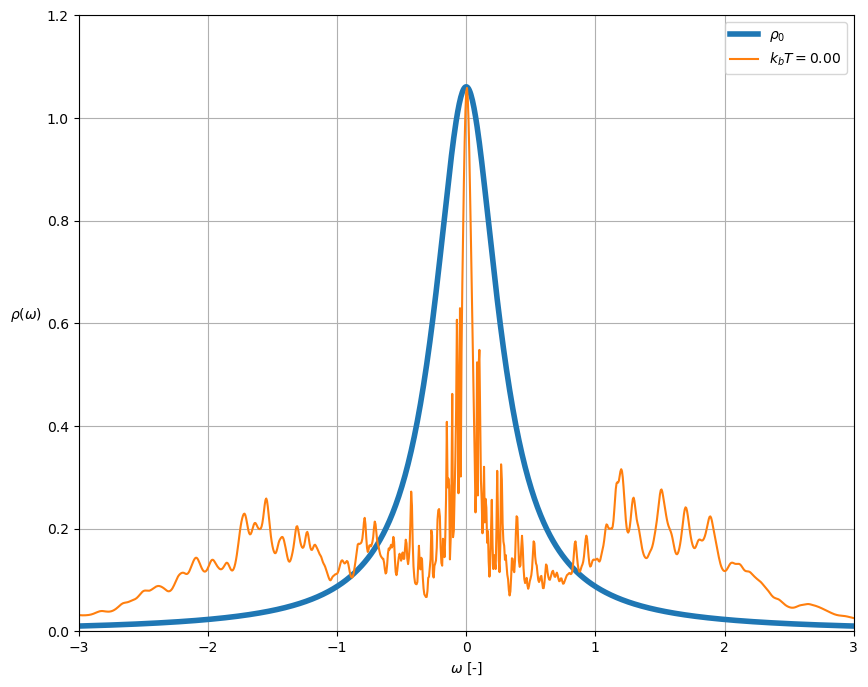

In [79]:
for l in range(len(Tk)):
    #AvgSigmadat+=Sigma
    #if l==0:
    #    Ed=-AvgSigmadat[500]
    finalG=np.nan_to_num(1/(omega-AvgSigmadat[l]/BoltzmannT[l]+1j*Gamma))
    fDOS[l]=-np.imag(finalG)/np.pi
print(BoltzmannT)
print(AvgSigmadat[0][500])
#fDOS3=-np.imag(noninttot3)/np.pi
#fDOS4=-np.imag(noninttot4)/np.pi
plt.figure(figsize=(10,8))
plt.xlim(min(omega), max(omega))
plt.gca().set_ylim(bottom=0,top=1.2)
plt.xlabel("$\\omega$ [-]")
plt.gca().set_ylabel("$\\rho$($\\omega$)",va="bottom", rotation=0,labelpad=15)
plt.plot(omega,Lorentzian(omega,Gamma,poles)[0],linewidth=4,label='$\\rho_0$')
for i in range(len(Tk)):
    plt.plot(omega, fDOS[i],label='$k_bT= %.2f$'%Tk[i])
#plt.plot(omega, fDOS3,label='$\\rho$')
#plt.plot(omega, fDOS4,label='$\\rho$')
plt.legend()
plt.grid()

In [82]:
(AvgSigmadat[0]/BoltzmannT[0])[490:510]

array([ 0.49091373-7.67099703e-02j,  0.30912498-2.08958070e-02j,
        0.19410319-2.52804103e-02j,  0.48496554-2.06382363e-01j,
        0.25556128-1.04838537e-02j,  0.19433111-4.72698776e-03j,
        0.15311361-2.96706312e-03j,  0.11854428-1.96501523e-03j,
        0.08714454-1.21981048e-03j,  0.05748643-5.86269833e-04j,
        0.02880866-4.72740325e-06j,  0.00061985-5.66166669e-04j,
       -0.02745394-1.12980907e-03j, -0.05574429-1.71534427e-03j,
       -0.08459029-2.34490299e-03j, -0.11438613-3.04832359e-03j,
       -0.14564506-3.87177474e-03j, -0.17910843-4.89546816e-03j,
       -0.21596474-6.27626192e-03j, -0.25836279-8.36898695e-03j])

[749.+0.j]
(-7.494753701737444-0.005023798314678874j)


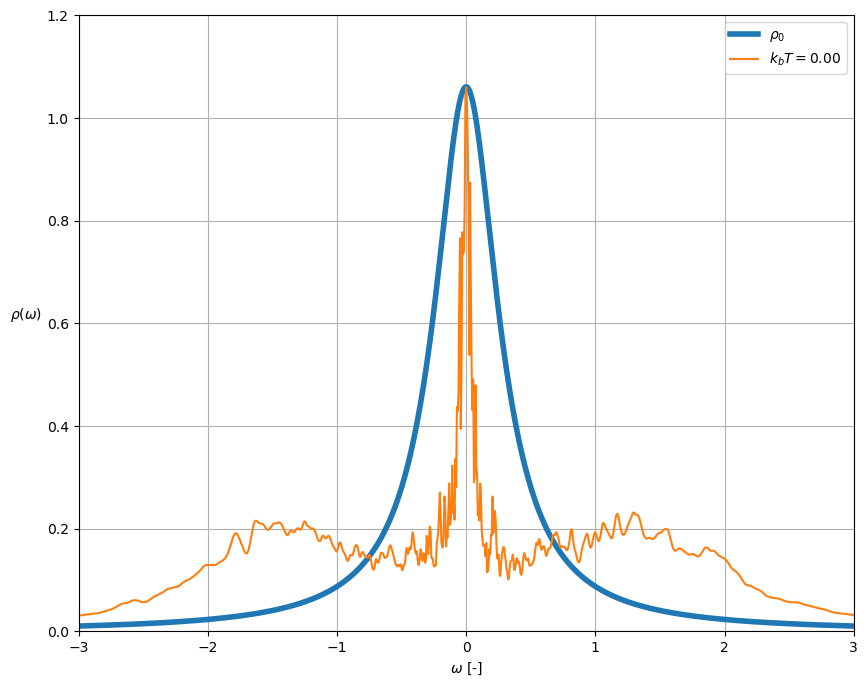

In [22]:
for l in range(len(Tk)):
    #AvgSigmadat+=Sigma
    #if l==0:
    #    Ed=-AvgSigmadat[500]
    finalG=np.nan_to_num(1/(omega-AvgSigmadat[l]/BoltzmannT[l]+1j*Gamma))
    fDOS[l]=-np.imag(finalG)/np.pi
print(BoltzmannT)
print(AvgSigmadat[0][500])
#fDOS3=-np.imag(noninttot3)/np.pi
#fDOS4=-np.imag(noninttot4)/np.pi
plt.figure(figsize=(10,8))
plt.xlim(min(omega), max(omega))
plt.gca().set_ylim(bottom=0,top=1.2)
plt.xlabel("$\\omega$ [-]")
plt.gca().set_ylabel("$\\rho$($\\omega$)",va="bottom", rotation=0,labelpad=15)
plt.plot(omega,Lorentzian(omega,Gamma,poles)[0],linewidth=4,label='$\\rho_0$')
for i in range(len(Tk)):
    plt.plot(omega, fDOS[i],label='$k_bT= %.2f$'%Tk[i])
#plt.plot(omega, fDOS3,label='$\\rho$')
#plt.plot(omega, fDOS4,label='$\\rho$')
plt.legend()
plt.grid()

[154.+0.j]
(-0.7681709136477068-0.0008990375210033732j)


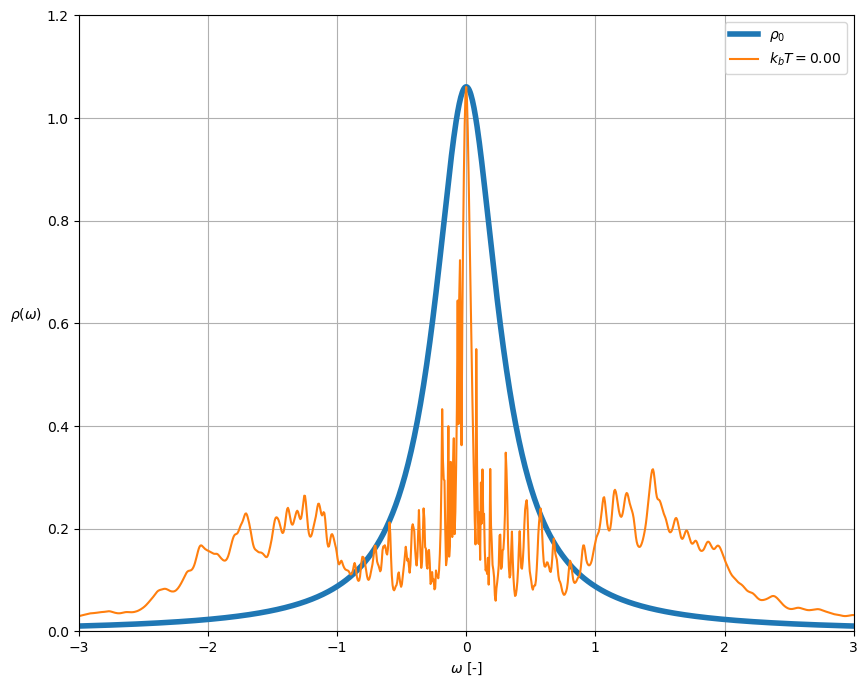

In [16]:
for l in range(len(Tk)):
    #AvgSigmadat+=Sigma
    #if l==0:
    #    Ed=-AvgSigmadat[500]
    finalG=np.nan_to_num(1/(omega-AvgSigmadat[l]/BoltzmannT[l]+1j*Gamma))
    fDOS[l]=-np.imag(finalG)/np.pi
print(BoltzmannT)
print(AvgSigmadat[0][500])
#fDOS3=-np.imag(noninttot3)/np.pi
#fDOS4=-np.imag(noninttot4)/np.pi
plt.figure(figsize=(10,8))
plt.xlim(min(omega), max(omega))
plt.gca().set_ylim(bottom=0,top=1.2)
plt.xlabel("$\\omega$ [-]")
plt.gca().set_ylabel("$\\rho$($\\omega$)",va="bottom", rotation=0,labelpad=15)
plt.plot(omega,Lorentzian(omega,Gamma,poles)[0],linewidth=4,label='$\\rho_0$')
for i in range(len(Tk)):
    plt.plot(omega, fDOS[i],label='$k_bT= %.2f$'%Tk[i])
#plt.plot(omega, fDOS3,label='$\\rho$')
#plt.plot(omega, fDOS4,label='$\\rho$')
plt.legend()
plt.grid()

[83.+0.j]
(0.367973216616631-0.0005803255814447657j)


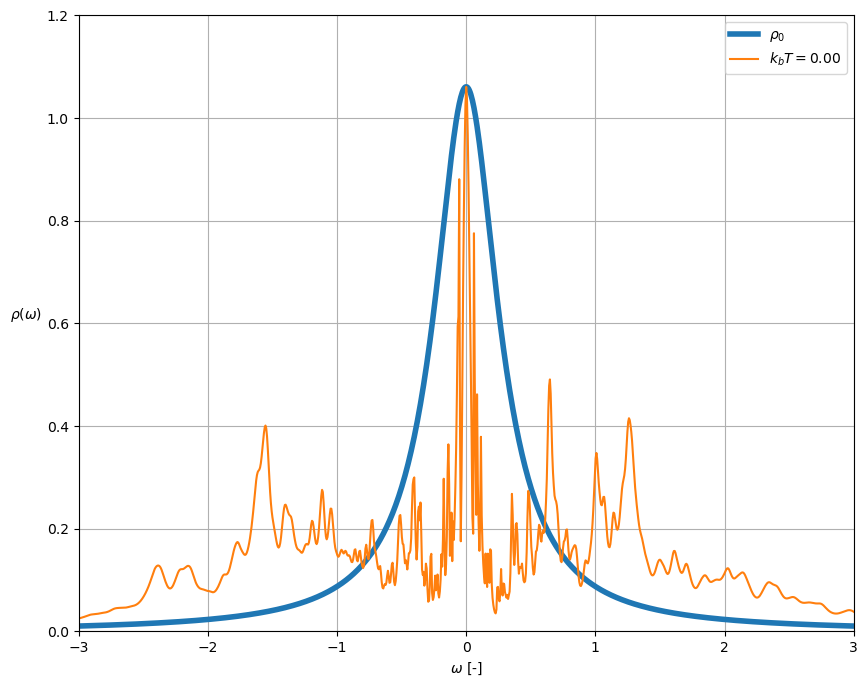

In [10]:
for l in range(len(Tk)):
    #AvgSigmadat+=Sigma
    #if l==0:
    #    Ed=-AvgSigmadat[500]
    finalG=np.nan_to_num(1/(omega-AvgSigmadat[l]/BoltzmannT[l]+1j*Gamma))
    fDOS[l]=-np.imag(finalG)/np.pi
print(BoltzmannT)
print(AvgSigmadat[0][500])
#fDOS3=-np.imag(noninttot3)/np.pi
#fDOS4=-np.imag(noninttot4)/np.pi
plt.figure(figsize=(10,8))
plt.xlim(min(omega), max(omega))
plt.gca().set_ylim(bottom=0,top=1.2)
plt.xlabel("$\\omega$ [-]")
plt.gca().set_ylabel("$\\rho$($\\omega$)",va="bottom", rotation=0,labelpad=15)
plt.plot(omega,Lorentzian(omega,Gamma,poles)[0],linewidth=4,label='$\\rho_0$')
for i in range(len(Tk)):
    plt.plot(omega, fDOS[i],label='$k_bT= %.2f$'%Tk[i])
#plt.plot(omega, fDOS3,label='$\\rho$')
#plt.plot(omega, fDOS4,label='$\\rho$')
plt.legend()
plt.grid()

[2324.+0.j]
(-13.153339681282315-0.013768165507542226j)


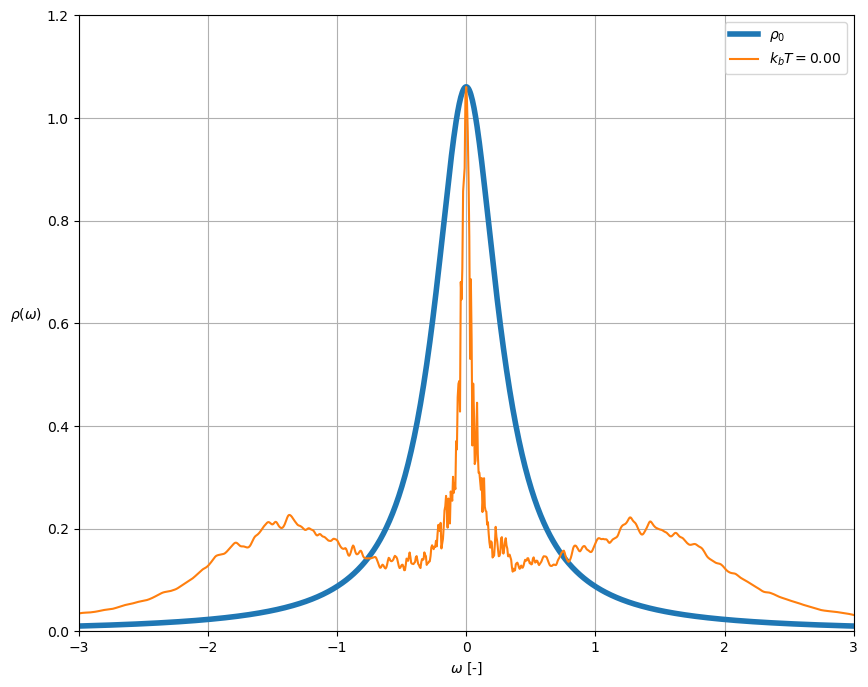

In [13]:
for l in range(len(Tk)):
    #AvgSigmadat+=Sigma
    #if l==0:
    #    Ed=-AvgSigmadat[500]
    finalG=np.nan_to_num(1/(omega-AvgSigmadat[l]/BoltzmannT[l]+1j*Gamma))
    fDOS[l]=-np.imag(finalG)/np.pi
print(BoltzmannT)
print(AvgSigmadat[0][500])
#fDOS3=-np.imag(noninttot3)/np.pi
#fDOS4=-np.imag(noninttot4)/np.pi
plt.figure(figsize=(10,8))
plt.xlim(min(omega), max(omega))
plt.gca().set_ylim(bottom=0,top=1.2)
plt.xlabel("$\\omega$ [-]")
plt.gca().set_ylabel("$\\rho$($\\omega$)",va="bottom", rotation=0,labelpad=15)
plt.plot(omega,Lorentzian(omega,Gamma,poles)[0],linewidth=4,label='$\\rho_0$')
for i in range(len(Tk)):
    plt.plot(omega, fDOS[i],label='$k_bT= %.2f$'%Tk[i])
#plt.plot(omega, fDOS3,label='$\\rho$')
#plt.plot(omega, fDOS4,label='$\\rho$')
plt.legend()
plt.grid()

[730.+0.j]
(-2.7749518668788125-0.0048210113314010785j)


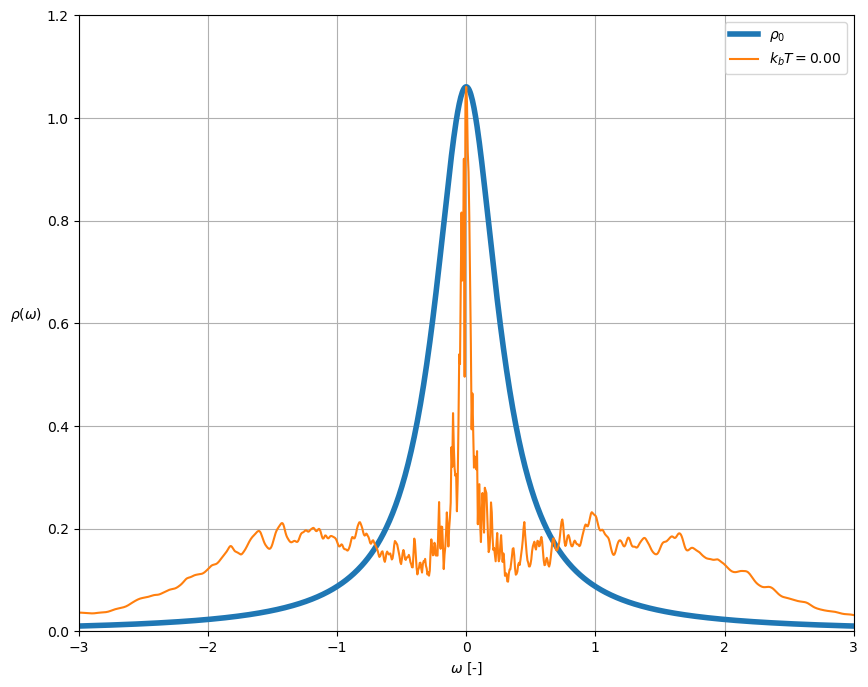

In [9]:
for l in range(len(Tk)):
    #AvgSigmadat+=Sigma
    #if l==0:
    #    Ed=-AvgSigmadat[500]
    finalG=np.nan_to_num(1/(omega-AvgSigmadat[l]/BoltzmannT[l]+1j*Gamma))
    fDOS[l]=-np.imag(finalG)/np.pi
print(BoltzmannT)
print(AvgSigmadat[0][500])
#fDOS3=-np.imag(noninttot3)/np.pi
#fDOS4=-np.imag(noninttot4)/np.pi
plt.figure(figsize=(10,8))
plt.xlim(min(omega), max(omega))
plt.gca().set_ylim(bottom=0,top=1.2)
plt.xlabel("$\\omega$ [-]")
plt.gca().set_ylabel("$\\rho$($\\omega$)",va="bottom", rotation=0,labelpad=15)
plt.plot(omega,Lorentzian(omega,Gamma,poles)[0],linewidth=4,label='$\\rho_0$')
for i in range(len(Tk)):
    plt.plot(omega, fDOS[i],label='$k_bT= %.2f$'%Tk[i])
#plt.plot(omega, fDOS3,label='$\\rho$')
#plt.plot(omega, fDOS4,label='$\\rho$')
plt.legend()
plt.grid()
#print(Ed)

In [ ]:
fDOS[i][495:505]

: 

In [ ]:
fDOS[i][500]

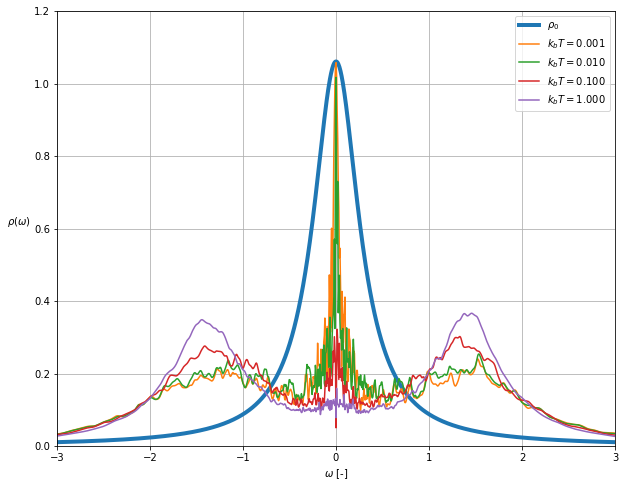

In [5]:
fDOS3=-np.imag(noninttot3)/np.pi
fDOS4=-np.imag(noninttot4)/np.pi
plt.figure(figsize=(10,8))
plt.xlim(min(omega), max(omega))
plt.gca().set_ylim(bottom=0,top=1.2)
plt.xlabel("$\\omega$ [-]")
plt.gca().set_ylabel("$\\rho$($\\omega$)",va="bottom", rotation=0,labelpad=15)
plt.plot(omega,Lorentzian(omega,Gamma,poles)[0],linewidth=4,label='$\\rho_0$')
for i in range(1,len(Tk)):
    plt.plot(omega, fDOS[i],label='$k_bT= %.3f$'%Tk[i])
#plt.plot(omega, fDOS3,label='$\\rho$')
#plt.plot(omega, fDOS4,label='$\\rho$')
plt.legend()
plt.grid(b='on')

In [6]:
# Defining the Jordan Wigner transformation for a 1D lattice
def jordan_wigner_transform(j, lattice_length):
    for k in range(j):
        if k == 0:
            operators = sigmaz()
        else:
            operators = tensor(operators, sigmaz())
    if j == 0:
        operators = sigmap()
    else:
        operators = tensor(operators, sigmap())
    for k in range(lattice_length - j - 1):
        operators = tensor(operators, identity(2))
    return operators

# Define rho0 distribution
def Lorentzian(omega, Gamma, poles):
    Rho0 = Gamma / np.pi / (omega ** 2 + Gamma ** 2)
    p = np.random.uniform(0, 1, poles)
    Rhoint = np.zeros(poles)
    for i in range(len(p)):
        Rhoint[i] = Gamma * math.tan(np.pi * (p[i] - 1 / 2))  ###p[i]-1/2
    return Rho0, Rhoint

# Calculates parameters impengergy,bathenergy and Vkk from random sampling distribution
def nonintG(omega, eta, select):
    G = 0
    for i in range(len(select)):
        G = G + 1 / len(select) / (omega - select[i] + 1.j * eta)
    return G

def HamiltonianAIM(c, impengergy, bathenergy, Vkk, U, Sigma):
    H = 0
    for i in range(2):
        H += impengergy * (c[i].dag() * c[i])
        for j in range(len(bathenergy)):
            H += Vkk[j] * (c[i].dag() * c[2 * j + i + 2] + c[2 * j + i + 2].dag() * c[i])
            H += bathenergy[j] * (c[2 * j + i + 2].dag() * c[2 * j + i + 2])
    exp = np.dot(H.eigenstates()[1][0].dag(), np.dot(n, H.eigenstates()[1][0]))
    H += U * (c[0].dag() * c[0] * c[1].dag() * c[1])
    H += -Sigma * (c[0].dag() * c[0] + c[1].dag() * c[1])
    return H,exp

def MBGAIM(omega, eigs, c, eta):
    MBG = np.zeros(len(omega),dtype = 'complex_')
    for i in range(1, len(eigs[0])):
        exp=np.dot(eigs[1][i].dag(),np.dot(c[0],eigs[1][0]))#m
        exp2=np.dot(eigs[1][0].dag(),np.dot(c[0].dag(),eigs[1][i]))#j
        exp3=np.dot(eigs[1][i].dag(),np.dot(c[0].dag(),eigs[1][0]))
        exp4=np.dot(eigs[1][0].dag(),np.dot(c[0],eigs[1][i]))
        k=exp[0][0]*exp2[0][0]
        l=exp3[0][0]*exp4[0][0]
        final = k / (omega + eigs[0][i] - eigs[0][0] + 1.j * eta) + l / (omega + eigs[0][0] - eigs[0][i] + 1.j * eta)
        MBG += final
    return MBG

# Gives Green’s function for the impurity level in the full interacting system (up and down spin)
def AIMsolver(impengergy, bathenergy, Vkk, U, Sigma, omega, eta, c,reset):
    H,exp2 = HamiltonianAIM(c, impengergy, bathenergy, Vkk, U, Sigma)
    eigs=H.eigenstates()
    exp = np.dot(eigs[1][0].dag(), np.dot(n, eigs[1][0]))
    if exp==exp2:
        reset=True
    MBG = MBGAIM(omega, eigs, c, eta)
    return MBG,reset

def Pcal(poles,pos):
    di=np.full((poles-1, poles), np.zeros(poles))
    for i in range(poles-1):
        for j in range(poles-1):
            if j>=i:
                di[i][j+1]=-1/sqrt((poles-i-1)*(poles-i))
        di[i][i]=sqrt(poles-i-1)/sqrt(poles-i)
    di=np.insert(di, pos,1/sqrt(poles),axis=0)
    return di

def DPgen(poles,select,pos):
    Pbath =np.array(Pcal(poles,pos))
    s = (poles,poles)
    Dbath=np.zeros(s)
    for i in range(len(select)):
        Dbath[i][i]=select[i]
    M=np.dot(Pbath,np.dot(Dbath,Pbath.T))
    return M

def startrans(poles,select,row,col):
    ham_mat=DPgen(poles,select,row)
    Hkk=np.delete(np.delete(ham_mat,row,axis=0),row,axis=1)
    eigkk,veckk=np.linalg.eig(Hkk)
    pbar=np.insert(np.insert(veckk, row,0,axis=0),row,0,axis=1)
    pbar[row][row]=1
    Hp=np.dot(pbar.T,np.dot(ham_mat,pbar))
    return Hp

In [7]:
AvgSigmadat2=np.zeros(len(omega),dtype = 'complex_')
noninttot3=0
noninttot4=0
for i in tqdm(range(N)):
    reset=False
    while not reset:
        select=sorted(Lorentzian(omega, Gamma, poles)[1])
        NewM=startrans(poles,select,0,0)
        bathenergy=[]
        impengergy=NewM[0][0]
        for k in range(len(NewM)-1):
            bathenergy.append(NewM[k+1][k+1])
        Vkk=NewM[0,1:]
        MBGdat,reset=AIMsolver(impengergy, bathenergy, Vkk, U,Sigma,omega,eta,c,reset)
    NewSigmadat=1/nonintG(omega,eta,select)-1/MBGdat+Sigma
    AvgSigmadat2=AvgSigmadat2+NewSigmadat/N
    noninttot3+=nonintG(omega,eta,select)/N
    noninttot4+=MBGdat/N
    #print(AvgSigmadat[600]*N/(i+1)-Sigma, end='\r')

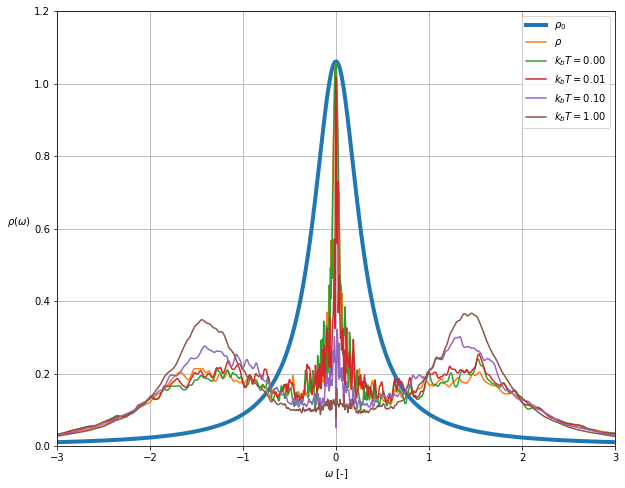

In [8]:
Ed=-Sigma
finalG2=np.nan_to_num(1/(omega-AvgSigmadat2-Ed+1j*Gamma))
fDOS2=-np.imag(finalG2)/np.pi
fDOS3=-np.imag(noninttot3)/np.pi
fDOS4=-np.imag(noninttot4)/np.pi
plt.figure(figsize=(10,8))
plt.xlim(min(omega), max(omega))
plt.gca().set_ylim(bottom=0,top=1.2)
plt.xlabel("$\\omega$ [-]")
plt.gca().set_ylabel("$\\rho$($\\omega$)",va="bottom", rotation=0,labelpad=15)
plt.plot(omega,Lorentzian(omega,Gamma,poles)[0],linewidth=4,label='$\\rho_0$')
plt.plot(omega, fDOS2,label='$\\rho$')
plt.plot(omega, fDOS[0],label='$k_bT= %.2f$'%Tk[0])
for i in range(2,len(Tk)):
    plt.plot(omega, fDOS[i],label='$k_bT= %.2f$'%Tk[i])
#plt.plot(omega, fDOS3,label='$\\rho$')
#plt.plot(omega, fDOS4,label='$\\rho$')
plt.legend()
plt.grid(b='on')

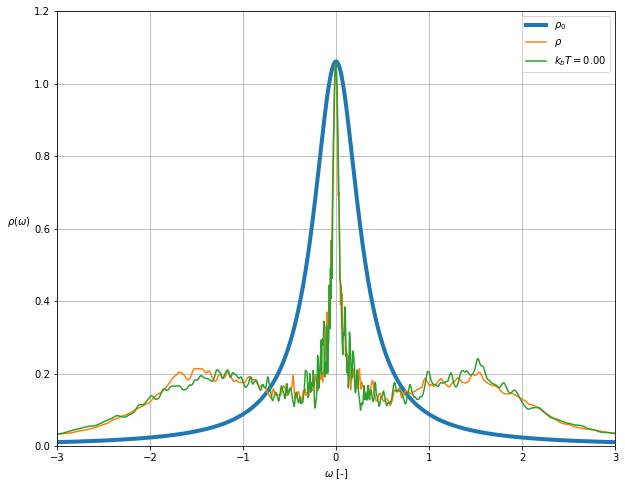

In [9]:
plt.figure(figsize=(10,8))
plt.xlim(min(omega), max(omega))
plt.gca().set_ylim(bottom=0,top=1.2)
plt.xlabel("$\\omega$ [-]")
plt.gca().set_ylabel("$\\rho$($\\omega$)",va="bottom", rotation=0,labelpad=15)
plt.plot(omega,Lorentzian(omega,Gamma,poles)[0],linewidth=4,label='$\\rho_0$')
plt.plot(omega, fDOS2,label='$\\rho$')
plt.plot(omega, fDOS[0],label='$k_bT= %.2f$'%Tk[0])
#for i in range(2,len(Tk)):
    #plt.plot(omega, fDOS[i],label='$k_bT= %.2f$'%Tk[i])
#plt.plot(omega, fDOS3,label='$\\rho$')
#plt.plot(omega, fDOS4,label='$\\rho$')
plt.legend()
plt.grid(b='on')

In [10]:
FinSigmadat2=[omega,fDOS2,fDOS[0],fDOS[1],fDOS[2],fDOS[3],fDOS[4]]

np.savetxt('DEDTscv342',np.transpose(FinSigmadat2), fmt='%.18g', delimiter='\t', newline='\n')
text_file = open("DEDTscv342", "r")
lines = text_file.read().split('\n')
print(lines[0])
text_file.close()

 (-3+0j)	 (0.0318690559082349806+0j)	 (0.0330572647930353902+0j)	 (0.0328985608960802103+0j)	 (0.0320770262733590453+0j)	 (0.0312905425341765825+0j)	 (0.0274348335501523183+0j)


In [14]:
FinSigmadat2=[omega,AvgSigmadat2,AvgSigmadat[0]/BoltzmannT[0],
              AvgSigmadat[1]/BoltzmannT[1],AvgSigmadat[2]/BoltzmannT[2],
              AvgSigmadat[3]/BoltzmannT[3],AvgSigmadat[4]/BoltzmannT[4]]

np.savetxt('DEDTSigmadatv2',np.transpose(FinSigmadat2), fmt='%.18g', delimiter='\t', newline='\n')
text_file = open("DEDTSigmadatv2", "r")
lines = text_file.read().split('\n')
print(lines[0])
text_file.close()

 (-3+0j)	 (0.900524325022610594-0.314781709557639511j)	 (-0.635853532183180525-0.320426851943998225j)	 (-0.641185358052493104-0.314029372544639196j)	 (-0.652843691260423631-0.290285599515800741j)	 (-0.696711437832498004-0.251393725066098472j)	 (-0.690555669697570762-0.179509680154068429j)


[ 771.        +0.j  779.52445341+0.j  871.19806835+0.j 1279.94063429+0.j
 1748.07522575+0.j]


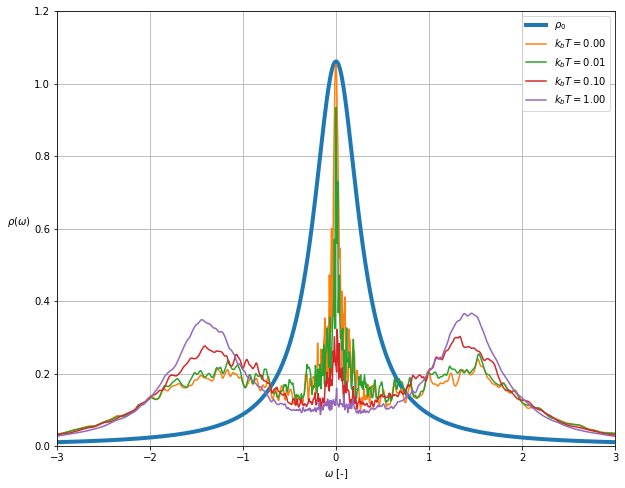

In [15]:
for l in range(len(Tk)):
    AvgSigmadat3=np.zeros(len(omega),dtype = 'complex_')
    for k in range(len(AvgSigmadat[l])):
        if omega[k]==0:
            AvgSigmadat3[k]=AvgSigmadat3[k-1]
        else:
            AvgSigmadat3[k]=AvgSigmadat[l][k]
    #AvgSigmadat+=Sigma
    #if l==0:
    #    Ed=-AvgSigmadat[500]
    finalG=np.nan_to_num(1/(omega-AvgSigmadat3/BoltzmannT[l]+1j*Gamma))
    fDOS[l]=-np.imag(finalG)/np.pi
plt.figure(figsize=(10,8))
plt.xlim(min(omega), max(omega))
plt.gca().set_ylim(bottom=0,top=1.2)
plt.xlabel("$\\omega$ [-]")
plt.gca().set_ylabel("$\\rho$($\\omega$)",va="bottom", rotation=0,labelpad=15)
plt.plot(omega,Lorentzian(omega,Gamma,poles)[0],linewidth=4,label='$\\rho_0$')
for i in range(1,len(Tk)):
    plt.plot(omega, fDOS[i],label='$k_bT= %.2f$'%Tk[i])
#plt.plot(omega, fDOS3,label='$\\rho$')
#plt.plot(omega, fDOS4,label='$\\rho$')
plt.legend()
plt.grid(b='on')
print(BoltzmannT)